<a href="https://colab.research.google.com/github/Light896cart/CV/blob/main/YOLOv1/Detection_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

import torchvision
import torchvision.transforms as transforms

import math
import xml.etree.ElementTree as ET
from PIL import Image
import os

In [48]:
class DataFurcts(Dataset):
  def __init__(self,path,transform):
    self.path = path
    self.transform = transform

    xml_files = [xml_files for xml_files in os.listdir(path) if xml_files.endswith('.xml')]
    self.dataset = list(self._XML_data(xml_files,path))  # Изменено на список
    print(self.dataset)

  def __getitem__(self, idx):
    sample = self.dataset[idx]['filename']
    img = Image.open(f'{self.path}/{sample}').convert('RGB')

    if self.transform:
      img = self.transform(img)


    # Получаем размеры изображения для нормализации
    width, height = img.shape[1:3]
    if self.dataset[idx]['label'] == 'orange':
      label = torch.tensor([1,0,0,0], dtype=torch.float)
    elif self.dataset[idx]['label'] == 'apple':
      label = torch.tensor([0,1,0,0], dtype=torch.float)
    elif self.dataset[idx]['label'] == 'banana':
      label = torch.tensor([0,0,1,0], dtype=torch.float)
    else:
      label = torch.tensor([0,0,0,1], dtype=torch.float)

    # Нормализуем координаты
    bndbox = self.dataset[idx]['bndbox']

    nor_bndbox = {
        'xmin': bndbox['xmin'],
        'ymin': bndbox['ymin'],
        'xmax': bndbox['xmax'],
        'ymax': bndbox['ymax'],
    }

    xmin = bndbox['xmin']
    ymin = bndbox['ymin']
    xmax = bndbox['xmax']
    ymax = bndbox['ymax']

    width_cell = xmax - xmin
    height_cell = ymax - ymin

    center_x = xmin + width_cell / 2
    center_y = ymin + height_cell / 2
    grid_x = center_x / (448 / 7)
    grid_y = center_y / (448 / 7)

    x_cell = math.floor(grid_x)
    y_cell = math.floor(grid_y)

    normalized_bndbox = {
        'grid_x':grid_x,
        'grid_y':grid_y,
        'x_cell' : x_cell,
        'y_cell' : y_cell,
        'width_cell' : width_cell,
        'height_cell' : height_cell
    }


    return img, nor_bndbox, label


  def __len__(self):
    return len(self.dataset)

  def _XML_data(self, xml_files, path):
    for file in xml_files:
        try:
            # Загрузка и парсинг XML файла
            tree = ET.parse(os.path.join(path, file))
            root = tree.getroot()

            # Извлечение данных
            filename = root.find('filename').text
            label = root.find('./object/name').text

            # Извлечение координат из bndbox
            bndbox = root.find('./object/bndbox')
            if bndbox is None:
                continue  # Переход к следующему файлу, если bndbox отсутствует

            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            yield {'filename': filename, 'label': label, 'bndbox': {'xmin':torch.tensor(xmin), 'ymin': torch.tensor(ymin), 'xmax': torch.tensor(xmax), 'ymax': torch.tensor(ymax)}}
        except Exception as e:
                print(f"Ошибка {file}: {e}")

In [49]:
transform = transforms.Compose([
            transforms.ToTensor(),  # Преобразует изображение в тензор
            transforms.Resize((448,448)),
            ])

In [50]:
path = '/content/fructs/train_zip/train'
daset = DataFurcts(path,transform)
data_train = DataLoader(daset,shuffle=True,batch_size=8)

[{'filename': 'banana_68.jpg', 'label': 'banana', 'bndbox': {'xmin': tensor(470.), 'ymin': tensor(161.), 'xmax': tensor(992.), 'ymax': tensor(495.)}}, {'filename': 'banana_35.jpg', 'label': 'banana', 'bndbox': {'xmin': tensor(74.), 'ymin': tensor(83.), 'xmax': tensor(243.), 'ymax': tensor(191.)}}, {'filename': 'banana_67.jpg', 'label': 'banana', 'bndbox': {'xmin': tensor(19.), 'ymin': tensor(21.), 'xmax': tensor(337.), 'ymax': tensor(325.)}}, {'filename': 'banana_49.jpg', 'label': 'banana', 'bndbox': {'xmin': tensor(95.), 'ymin': tensor(63.), 'xmax': tensor(597.), 'ymax': tensor(266.)}}, {'filename': 'orange_32.jpg', 'label': 'orange', 'bndbox': {'xmin': tensor(50.), 'ymin': tensor(98.), 'xmax': tensor(248.), 'ymax': tensor(289.)}}, {'filename': 'apple_51.jpg', 'label': 'apple', 'bndbox': {'xmin': tensor(43.), 'ymin': tensor(68.), 'xmax': tensor(229.), 'ymax': tensor(250.)}}, {'filename': 'banana_53.jpg', 'label': 'banana', 'bndbox': {'xmin': tensor(4.), 'ymin': tensor(92.), 'xmax': te

In [52]:
for c in data_train:
  gt_tensor = torch.stack(list(c[1].values()), dim=1).view(-1,4)
  print(gt_tensor)

tensor([[  57.,  215., 1711., 1112.],
        [  45.,   57.,  214.,  212.],
        [ 146.,    6.,  650.,  533.],
        [  77.,  230.,  841.,  572.],
        [  71.,   18.,  258.,  220.],
        [  88.,  123.,  225.,  282.],
        [ 125.,  196.,  295.,  374.],
        [   4.,   71.,  366.,  398.]])
tensor([[1.4400e+02, 4.6000e+01, 3.4000e+02, 2.9100e+02],
        [1.7100e+02, 2.3600e+02, 8.5900e+02, 7.5600e+02],
        [1.7000e+01, 1.0000e+00, 1.5900e+03, 6.2400e+02],
        [2.6000e+01, 5.6000e+01, 2.2200e+02, 2.3900e+02],
        [1.3600e+02, 1.1700e+02, 2.4000e+02, 2.2400e+02],
        [1.3200e+02, 9.8000e+01, 5.9100e+02, 3.4800e+02],
        [1.5900e+02, 4.5000e+01, 5.2000e+02, 3.3600e+02],
        [2.5000e+01, 4.0000e+01, 9.1700e+02, 5.2700e+02]])
tensor([[  27.,   72.,  521.,  319.],
        [ 261.,  278.,  864.,  889.],
        [ 470.,  161.,  992.,  495.],
        [  56.,  113.,  278.,  332.],
        [ 184.,  221., 1226.,  712.],
        [  26.,   69.,  604.,  581.],
  

KeyboardInterrupt: 

In [7]:
class YOLODetection(nn.Module):
    def __init__(self, input_channels,S,C,B,batch_size):
        super(YOLODetection, self).__init__()

        self.batch_size = batch_size
        self.S = S
        self.C = C

        self.backbone = nn.Sequential(
            self._make_layer(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._make_layer(64, 192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._make_segment_3(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._make_segment_4(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._make_segment_5(),
            nn.Flatten(),
            nn.Linear(in_features=50176,out_features=4096),
            nn.Linear(in_features=4096,out_features=S * S * (B * 5 + C)),
            nn.Sigmoid()
        )

    def _make_layer(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU()
        ]
        return nn.Sequential(*layers)

    def _make_segment_3(self):
        return nn.Sequential(
            self._make_layer(192, 128, 1),
            self._make_layer(128, 256, 3),
            self._make_layer(256, 256, 1),
            self._make_layer(256, 512, 3, padding=2)
        )

    def _make_segment_4(self):
      layers = nn.ModuleList()

      for _ in range(4):
          layers.append(self._make_layer(512, 256, kernel_size=1, padding=0))
          layers.append(self._make_layer(256, 512, kernel_size=3, padding=0))

      layers.append(self._make_layer(512, 512, 1,padding=2))
      layers.append(self._make_layer(512, 1024, 3,padding=3))

      return nn.Sequential(*layers)

    def _make_segment_5(self):
      layers = nn.ModuleList()

      for _ in range(2):
        layers.append(self._make_layer(1024, 512, kernel_size=1))
        layers.append(self._make_layer(512, 1024, kernel_size=1))

      layers.append(self._make_layer(1024, 1024, kernel_size=3,padding=1))
      layers.append(self._make_layer(1024, 1024, kernel_size=3,stride=2,padding=1))
      return nn.Sequential(*layers)

    def _transform(self,tenz):
      return tenz.view(self.batch_size,self.S*self.S,-1)

    def detection(self, tensor):
      # Получаем размеры батча и количество ячеек
      batch_size = tensor.size(0)
      num_cells = tensor.size(1)

      # Извлекаем уверенность и координаты ячеек
      confidence = tensor[:, :, 0]  # уверенность
      x_cell = tensor[:, :, 1]  # координаты в ячейке x
      y_cell = tensor[:, :, 2]  # координаты в ячейке y
      width_cell = tensor[:, :, 3]  # ширина
      height_cell = tensor[:, :, 4]  # высота

      # Преобразование x и y из ячейки в координаты изображения
      # Пропорциональное распределение по сетке
      grid_x = (x_cell + (torch.arange(num_cells).unsqueeze(0) % 7).float()) * (448 / 7)
      grid_y = (y_cell + (torch.arange(num_cells).unsqueeze(0) // 7).float()) * (448 / 7)

      xmin = grid_x - (width_cell / 2)
      ymin = grid_y - (height_cell / 2)
      xmax = grid_x + (width_cell / 2)
      ymax = grid_y + (height_cell / 2)

      # Объединяем тензоры
      output_tensor = torch.cat((confidence.unsqueeze(1), xmin.unsqueeze(1), ymin.unsqueeze(1), xmax.unsqueeze(1), ymax.unsqueeze(1)), dim=1).permute(0, 2, 1)
      return output_tensor

    def forward(self, x):
      x = self.backbone(x)
      x = self._transform(x)
      x = self.detection(x)
      return x


In [8]:

img = '/content/fructs/train_zip/train/apple_1.jpg'

img = transforms.ToTensor()(Image.open(img))[:3]
img = transforms.Resize((448,448))(img).unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 448, 448])


In [9]:
model = YOLODetection(input_channels=3,S=7,B=1,C=0,batch_size=1)


In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-6)

In [ ]:
# Истинная область (ground truth)
gt_bndbox = {
    'xmin': torch.tensor(62.).unsqueeze(0),
    'ymin': torch.tensor(77.).unsqueeze(0),
    'xmax': torch.tensor(245.).unsqueeze(0),
    'ymax': torch.tensor(267.).unsqueeze(0)
}

In [17]:
def IOU(prediction, label):
    # Получаем координаты из меток
    label_xmin = label[:, 0]
    label_ymin = label[:, 1]
    label_xmax = label[:, 2]
    label_ymax = label[:, 3]

    # Получаем координаты предсказания
    pred_xmin = prediction[:, :, 0]
    pred_ymin = prediction[:, :, 1]
    pred_xmax = prediction[:, :, 2]
    pred_ymax = prediction[:, :, 3]

    # Вычисляем координаты пересечения
    inter_xmin = torch.max(label_xmin.unsqueeze(1), pred_xmin)  # добавляем размерность
    inter_ymin = torch.max(label_ymin.unsqueeze(1), pred_ymin)
    inter_xmax = torch.min(label_xmax.unsqueeze(1), pred_xmax)
    inter_ymax = torch.min(label_ymax.unsqueeze(1), pred_ymax)

    # Площадь пересечения
    intersection_width = torch.clamp(inter_xmax - inter_xmin, min=0)
    intersection_height = torch.clamp(inter_ymax - inter_ymin, min=0)
    intersection_area = intersection_width * intersection_height

    # Площадь объединения
    label_area = (label_xmax - label_xmin) * (label_ymax - label_ymin)
    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)
    union_area = label_area.unsqueeze(1) + pred_area - intersection_area  # добавляем размерность к label_area

    # Вычисляем IOU
    iou = intersection_area / union_area
    _, max_index = torch.max(iou, dim=1)
    return max_index


In [53]:
# # Объединяем значения в один тензор
# gt_tensor = (torch.cat(list(gt_bndbox.values())))

# print(gt_tensor)
model.train()
for _ in range(50):
  for c in data_train:
    gt_tensor = torch.stack(list(c[1].values()), dim=1).view(-1,4)
    print(gt_tensor.shape)
    optimizer.zero_grad()
    output = model(c[0])
    reg = IOU(output,gt_tensor)
    loss = criterion(output[:, reg, 1:],gt_tensor)
    loss.backward()
    optimizer.step()
    print(loss)


torch.Size([8, 4])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 4])) that is different to the input size (torch.Size([1, 8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(149412.7031, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(134681.4219, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(901712.7500, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(423160.9688, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(260895.9375, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(124835.0938, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(91101.4297, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(268837.1875, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(700839.3750, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(169722.9219, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(114696.8047, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(42749.9961, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(59704.1055, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(120350.2109, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])
tensor(87940.1953, grad_fn=<MseLossBackward0>)
torch.Size([8, 4])

KeyboardInterrupt: 

In [54]:
output = model(img)
print(output)

tensor([[[  0.5511,  62.9670,  62.1489,  63.5138,  62.7541],
         [  0.4844, 103.5040,  23.6108, 104.0097,  24.1423],
         [  0.5251, 161.1347,  27.2594, 161.6173,  27.7597],
         [  0.4532, 221.0810,  29.3664, 221.6230,  29.8486],
         [  0.4665, 287.7046,  32.8796, 288.2076,  33.3718],
         [  0.4855, 351.1503,  26.4835, 351.6689,  26.9681],
         [  0.5178, 415.3580,  31.8297, 415.8105,  32.3937],
         [  0.5376,  30.2654,  98.2123,  30.7540,  98.7197],
         [  0.5097,  91.8913,  96.8876,  92.4349,  97.3938],
         [  0.5648, 172.3122,  78.5144, 172.8477,  79.0697],
         [  0.5190, 225.9078,  96.9175, 226.4064,  97.4147],
         [  0.5008, 283.0275,  94.7612, 283.5824,  95.2505],
         [  0.4714, 349.9601,  93.4102, 350.5313,  93.9485],
         [  0.4741, 412.6686,  97.5151, 413.1638,  98.0659],
         [  0.4734,  29.3927, 161.7198,  29.8411, 162.1956],
         [  0.5155,  97.5596, 159.8898,  98.0632, 160.4386],
         [  0.4848, 160.

In [ ]:
print(torch.tensor([3]) + torch.arange(49)%)

tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])


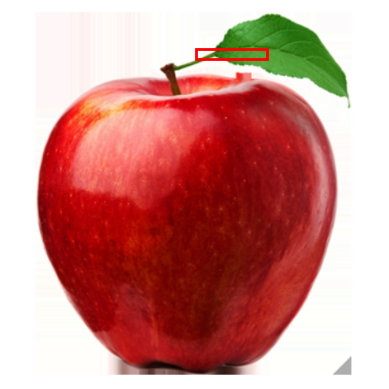

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Координаты бокса
xmin = 415.6635
ymin = 95.8135
xmax = 300.1645
ymax = 120.3093

# Преобразуем координаты в пиксели (в этом примере предполагаем, что изображение 100x100)
# Здесь нужно применить соотношения для корректного преобразования в зависимости от вашего изображения
height, width, _,_ = img.shape
x_img_min = int(xmin * (width / (width + 1)))  # Примерное соотношение
y_img_min = int(ymin * (height / (height + 1)))
x_img_max = int(xmax * (width / (width + 1)))
y_img_max = int(ymax * (height / (height + 1)))

# Отобразим изображение
plt.imshow(img.squeeze(0).permute(1,2,0))
# Создаем бокс
rect = patches.Rectangle((x_img_min, y_img_min), x_img_max - x_img_min, y_img_max - y_img_min,
                         linewidth=2, edgecolor='r', facecolor='none')

# Добавляем бокс на изображение
plt.gca().add_patch(rect)

# Отображаем результат
plt.axis('off')  # Скрыть оси, если не нужно их отображать
plt.show()


In [2]:
import zipfile

zip_file_name = '/content/archive.zip'
# Распаковка ZIP-файла в текущую директорию

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
  zip_ref.extractall('fructs')